# Stroke Prediction
Stroke is the 2nd highest cause of mortality in the world (WHO). Even if an individual survives a stroke, it is common that the individual has severe symptoms such as spasticity, cognitive problems etc.

Since stroke is a major health problem, it is crucial to know the risk factors that cause a stroke.In this dataset, we will investigate these factors and build a model that predicts stroke.

The data set contains 11 features and 1 target variable. The target variable is 'Stroke' column, which is binary data 0: No stroke, 1 : Stroke.  

Anyway, let's start digging.


#### Importing packages 

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from scipy import stats

pd.set_option('display.max_columns', 60)


import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

# metrics
from sklearn.metrics import accuracy_score, classification_report, auc, make_scorer
from sklearn.metrics import confusion_matrix, recall_score 
from sklearn.metrics import f1_score, precision_score, roc_curve, precision_recall_curve, roc_auc_score

# folds
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split


from xgboost import XGBClassifier

#saving scalers for deployment
import joblib

In [22]:
# Read the csv file
url = "https://raw.githubusercontent.com/orkunaran/Stroke-Prediction/main/healthcare-dataset-stroke-data.csv"
path = "stroke_data.csv"
df = pd.read_csv(path)

In [23]:
# First and last 5 rows of the data
display(df.head())

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Model Interpretation

In [24]:
#spare a validation dataset
X_train, X_val, y_train, y_val = train_test_split(
    df.drop('stroke',axis=1),
    df.stroke,
    test_size = 0.1, 
    stratify = df.stroke.values,
    random_state= 42
    )

In [25]:
df_train = X_train.copy(deep = True)
df_train['stroke'] = y_train

In [26]:
# creating folds
df_train["kfold"] = -1
# the next step is to randomize the rows of the data
df_train = df_train.sample(frac=1).reset_index(drop=True)
y = df_train.stroke.values
# initiate the kfold class from model_selection module
kf = StratifiedKFold(n_splits=10)
# fill the new kfold column
for f, (t_, v_) in enumerate(kf.split(X=df_train, y=y)):
  df_train.loc[v_, 'kfold'] = f

#df.to_csv('stroke_fold.csv', index = False)


In [27]:
def metrics(y_val, y_preds):
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  for yr, yp in zip(y_val,y_preds):
    if yr == 1 and yp == 1:
      tp += 1
    elif yr == 1 and yp == 0:
      fp +=1
    elif yr == 0 and yp == 0:
      tn += 1
    else:
      fn += 1

  return tp, fp, tn, fn


results = pd.DataFrame()

In [28]:
useful_features = [col for col in df_train.columns if col not in ['kfold','stroke']]
object_cols = [col for col in df_train.select_dtypes('object').columns]
numeric_cols = [col for col in df_train.columns if col not in object_cols and col not in ['kfold','stroke']]

weight = len(df_train) / (df_train.stroke.nunique() * np.bincount(df_train.stroke.values))
spw = weight[1] / weight[0]

final_predictions = []
for fold in range(10):
  xtrain =  df_train[df_train.kfold != fold].reset_index(drop=True)
  xvalid = df_train[df_train.kfold == fold].reset_index(drop=True)
  xtest = X_val.copy()

  ytrain = xtrain.stroke
  yvalid = xvalid.stroke

  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]

  ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
  xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
  xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
  xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])

  standart_scaler = StandardScaler()
  xtrain[numeric_cols] = standart_scaler.fit_transform(xtrain[numeric_cols])
  xvalid[numeric_cols] = standart_scaler.transform(xvalid[numeric_cols])
  xtest[numeric_cols] = standart_scaler.transform(xtest[numeric_cols])

  imputer = KNNImputer(n_neighbors=10)
  xtrain = pd.DataFrame(imputer.fit_transform(xtrain), columns = xtrain.columns)
  xvalid = pd.DataFrame(imputer.transform(xvalid), columns = xvalid.columns)
  xtest = pd.DataFrame(imputer.transform(xtest), columns = xtest.columns)

  clf = XGBClassifier(random_state=fold, n_jobs=4, scale_pos_weight = spw, eval_metric = 'logloss')
  clf.fit(xtrain, ytrain, eval_set=[(xvalid,yvalid)],early_stopping_rounds=300,verbose=False)
  preds_valid = clf.predict(xvalid)
  test_preds = clf.predict(xtest)
  final_predictions.append(test_preds)
  print(fold, f1_score(yvalid, preds_valid), precision_score(yvalid,preds_valid))

0 0.4878048780487805 0.5555555555555556
1 0.42857142857142855 0.47368421052631576
2 0.5405405405405405 0.7142857142857143
3 0.35000000000000003 0.3888888888888889
4 0.5581395348837208 0.5714285714285714
5 0.3829787234042554 0.36
6 0.46153846153846156 0.5294117647058824
7 0.4255319148936171 0.4
8 0.44 0.39285714285714285
9 0.5333333333333332 0.5454545454545454


In [29]:
finals = np.mean(np.column_stack(final_predictions), axis=1)

In [30]:
fpr, tpr, thresholds = roc_curve(y_val,finals)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

Best Threshold=0.200000, G-Mean=0.697


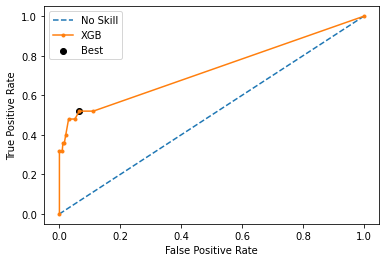

In [31]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGB')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [32]:
y_pred = [1 if x >= thresholds[ix] else 0 for x in finals]
tp, fp, tn, fn = metrics(y_val, y_pred)

results = results.append({'scale_pos_weight': spw,
                          'tp' : tp,
                          'fp' : fp,
                          'tn' : tn,
                          'fn' : fn,
                          'precision' : (tp / (tp + fp)),
                          'recall' : ((tp / (tp + fn)))},
                                      ignore_index = True)

In [33]:
results

,scale_pos_weight,tp,fp,tn,fn,precision,recall
0,17.316964,13.0,12.0,403.0,28.0,0.52,0.317073


In [34]:
ranges = [15,16,17,18,19,20,30,35,36]
for i in ranges:
  useful_features = [col for col in df_train.columns if col not in ['kfold','stroke']]
  object_cols = [col for col in df_train.select_dtypes('object').columns]
  numeric_cols = [col for col in df_train.columns if col not in object_cols and col not in ['kfold','stroke']]


  final_predictions = []
  final_valids = []
  for fold in range(10):
    xtrain =  df_train[df_train.kfold != fold].reset_index(drop=True)
    xvalid = df_train[df_train.kfold == fold].reset_index(drop=True)
    xtest = X_val.copy()

    ytrain = xtrain.stroke
    yvalid = xvalid.stroke

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
    xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
    xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])

    standart_scaler = StandardScaler()
    xtrain[numeric_cols] = standart_scaler.fit_transform(xtrain[numeric_cols])
    xvalid[numeric_cols] = standart_scaler.transform(xvalid[numeric_cols])
    xtest[numeric_cols] = standart_scaler.transform(xtest[numeric_cols])

    imputer = KNNImputer(n_neighbors=10)
    xtrain = pd.DataFrame(imputer.fit_transform(xtrain), columns = xtrain.columns)
    xvalid = pd.DataFrame(imputer.transform(xvalid), columns = xvalid.columns)
    xtest = pd.DataFrame(imputer.transform(xtest), columns = xtest.columns)

     
    clf = XGBClassifier(scale_pos_weight = i, random_state = fold, eval_metric = 'logloss')
    clf.fit(xtrain, ytrain, eval_set=[(xvalid,yvalid)],early_stopping_rounds=300,verbose=False)
    preds_valid = clf.predict(xvalid)
    test_preds = clf.predict(xtest)
    final_predictions.append(test_preds)
    

  finals = np.mean(np.column_stack(final_predictions), axis=1)
  fpr, tpr, thresholds = roc_curve(y_val,finals)
  # calculate the g-mean for each threshold
  gmeans = np.sqrt(tpr * (1-fpr))

  # locate the index of the largest g-mean
  ix = np.argmax(gmeans)

  y_pred = [1 if x >= thresholds[ix] else 0 for x in finals]

  tp, fp, tn, fn = metrics(y_val, y_pred)

  results = results.append({'scale_pos_weight': i ,
                          'tp' : tp,
                          'fp' : fp,
                          'tn' : tn,
                          'fn' : fn,
                          'precision' : (tp / (tp + fp)),
                          'recall' : ((tp / (tp + fn)))},
                                      ignore_index = True)

display(results)

,scale_pos_weight,tp,fp,tn,fn,precision,recall
0,17.316964,13.0,12.0,403.0,28.0,0.52,0.317073
1,15.000000,14.0,11.0,386.0,45.0,0.56,0.237288
2,16.000000,16.0,9.0,387.0,44.0,0.64,0.266667
3,17.000000,16.0,9.0,385.0,46.0,0.64,0.258065
4,18.000000,16.0,9.0,385.0,46.0,0.64,0.258065
5,19.000000,16.0,9.0,385.0,46.0,0.64,0.258065
6,20.000000,14.0,11.0,385.0,46.0,0.56,0.233333
7,30.000000,15.0,10.0,380.0,51.0,0.60,0.227273
8,35.000000,14.0,11.0,388.0,43.0,0.56,0.245614
9,36.000000,15.0,10.0,383.0,48.0,0.60,0.238095


In [35]:

useful_features = [col for col in df_train.columns if col not in ['kfold','stroke']]
object_cols = [col for col in df_train.select_dtypes('object').columns]
numeric_cols = [col for col in df_train.columns if col not in object_cols and col not in ['kfold','stroke']]

weight = len(df_train) / (df_train.stroke.nunique() * np.bincount(df_train.stroke.values))
spw = weight[1] / weight[0]

final_predictions = []
for fold in range(10):
  xtrain =  df_train[df_train.kfold != fold].reset_index(drop=True)
  xvalid = df_train[df_train.kfold == fold].reset_index(drop=True)
  xtest = X_val.copy()

  ytrain = xtrain.stroke
  yvalid = xvalid.stroke

  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]

  ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
  xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
  xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
  xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])

  standart_scaler = StandardScaler()
  xtrain[numeric_cols] = standart_scaler.fit_transform(xtrain[numeric_cols])
  xvalid[numeric_cols] = standart_scaler.transform(xvalid[numeric_cols])
  xtest[numeric_cols] = standart_scaler.transform(xtest[numeric_cols])

  imputer = KNNImputer(n_neighbors=10)
  xtrain = pd.DataFrame(imputer.fit_transform(xtrain), columns = xtrain.columns)
  xvalid = pd.DataFrame(imputer.transform(xvalid), columns = xvalid.columns)
  xtest = pd.DataFrame(imputer.transform(xtest), columns = xtest.columns)

  clf = XGBClassifier(random_state=fold, n_jobs=4, scale_pos_weight = 35, eval_metric = 'logloss')
  clf.fit(xtrain, ytrain, eval_set=[(xvalid,yvalid)],early_stopping_rounds=300,verbose=False)
  preds_valid = clf.predict(xvalid)
  test_preds = clf.predict(xtest)
  final_predictions.append(test_preds)
  print(fold, f1_score(yvalid, preds_valid), precision_score(yvalid,preds_valid))


finals = np.mean(np.column_stack(final_predictions), axis=1)
fpr, tpr, thresholds = roc_curve(y_val,finals)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

y_pred = [1 if x >= thresholds[ix] else 0 for x in finals]

tp, fp, tn, fn = metrics(y_val, y_pred)

0 0.4999999999999999 0.48
1 0.4186046511627907 0.45
2 0.4390243902439025 0.5
3 0.36363636363636365 0.36363636363636365
4 0.5454545454545454 0.5454545454545454
5 0.41666666666666663 0.38461538461538464
6 0.45454545454545453 0.45454545454545453
7 0.4090909090909091 0.4090909090909091
8 0.44897959183673464 0.4074074074074074
9 0.4999999999999999 0.48


In [36]:
#save the model
clf.save_model('xgb_model.json')


In [37]:
# save scalers

joblib.dump(ordinal_encoder, 'ordinal_encoder.gz')
joblib.dump(standart_scaler, 'standard_scaler.gz')
joblib.dump(imputer, 'knn_imputer.gz')

['knn_imputer.gz']